# Checking Substructure hits in molecules with known biological activity on Leishmania infantum NAD-dependent protein deacetylase (SIR2RP1)

In this notebook, the molecules with know acitivity for the NAD-dependent protein deacetylase (SIR2RP1), a <em> Leishmania infantum </em> sirtuin, will be downloaded from chembl. 
    
These molecules will be compared with the synthetically tractable fragments from the VEHICLe dataset. Fragments present wthin the molecules with biological activity will be analysed further.

In [575]:
#Importing Libraries

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.ML.Cluster import Butina
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

from rdkit.Chem import AllChem

from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [576]:
#Setting up the Path to save results

HERE = Path(_dh[-1])
DATA = HERE / "DATA"

## Downloading Activities from Chembl

In [577]:
#Link to chembl Target Report Card
#https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2311240/

chembl_id = "CHEMBL2311240" 

bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Number of bioactivities imported: {len(bioactivities)}")

Number of bioactivities imported: 21


In [578]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 12618266,
 'assay_chembl_id': 'CHEMBL2320160',
 'assay_description': 'Inhibition of Leishmania infantum SIR2RP1',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL508272',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '35200.0',
 'target_chembl_id': 'CHEMBL2311240',
 'target_organism': 'Leishmania infantum',
 'type': 'IC50',
 'units': 'uM',
 'value': '35.2'}

In [579]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df

DataFrame shape: (22, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,12618266,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,B,CHEMBL508272,=,nM,35200.0,CHEMBL2311240,Leishmania infantum,IC50,uM,35.2
1,12618266,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,B,CHEMBL508272,=,nM,35200.0,CHEMBL2311240,Leishmania infantum,IC50,uM,35.2
2,12618267,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,B,CHEMBL228002,=,nM,5700.0,CHEMBL2311240,Leishmania infantum,IC50,uM,5.7
3,12618268,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,B,CHEMBL228067,=,nM,9200.0,CHEMBL2311240,Leishmania infantum,IC50,uM,9.2
4,12618269,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,B,CHEMBL380797,=,nM,193800.0,CHEMBL2311240,Leishmania infantum,IC50,uM,193.8
5,12618271,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,B,CHEMBL1140,=,nM,39400.0,CHEMBL2311240,Leishmania infantum,IC50,uM,39.4
6,18482627,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,B,CHEMBL380797,=,nM,194000.0,CHEMBL2311240,Leishmania infantum,IC50,uM,194.0
7,18482628,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,B,CHEMBL1140,=,nM,40000.0,CHEMBL2311240,Leishmania infantum,IC50,uM,40.0
8,18482629,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,B,CHEMBL4216559,=,nM,5700.0,CHEMBL2311240,Leishmania infantum,IC50,uM,5.7
9,18482630,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,B,CHEMBL3040216,=,nM,7000.0,CHEMBL2311240,Leishmania infantum,IC50,uM,7.0


## Cleaning the data set

In [580]:
#Selecting only relevant collumns

bioactivities_df = bioactivities_df[['activity_id', 'assay_chembl_id', 'assay_description', 'molecule_chembl_id', 
                                     'standard_units', 'standard_value', 'type']]

In [581]:
#Checking varible types
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
molecule_chembl_id    object
standard_units        object
standard_value        object
type                  object
dtype: object

In [582]:
#Converting activities to float
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
molecule_chembl_id     object
standard_units         object
standard_value        float64
type                   object
dtype: object

In [583]:
#Dropping duplicates
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (19, 7)


In [584]:
#reset index
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,molecule_chembl_id,standard_units,standard_value,type
0,12618266,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL508272,nM,35200.0,IC50
1,12618267,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL228002,nM,5700.0,IC50
2,12618268,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL228067,nM,9200.0,IC50
3,12618269,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL380797,nM,193800.0,IC50
4,12618271,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL1140,nM,39400.0,IC50


In [585]:
#renaming collumns
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,molecule_chembl_id,units,IC50,type
0,12618266,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL508272,nM,35200.0,IC50
1,12618267,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL228002,nM,5700.0,IC50
2,12618268,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL228067,nM,9200.0,IC50
3,12618269,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL380797,nM,193800.0,IC50
4,12618271,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL1140,nM,39400.0,IC50


In [586]:
#Removing molecules with IC50 above 10.000 nM
bioactivities_df = bioactivities_df[bioactivities_df['IC50'] < 10000]
bioactivities_df

,activity_id,assay_chembl_id,assay_description,molecule_chembl_id,units,IC50,type
1,12618267,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL228002,nM,5700.0,IC50
2,12618268,CHEMBL2320160,Inhibition of Leishmania infantum SIR2RP1,CHEMBL228067,nM,9200.0,IC50
5,18482629,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,CHEMBL4216559,nM,5700.0,IC50
6,18482630,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,CHEMBL3040216,nM,7000.0,IC50
7,18482631,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,CHEMBL4211052,nM,5700.0,IC50
8,18482632,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,CHEMBL4204117,nM,5700.0,IC50
9,18482633,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,CHEMBL4215363,nM,5700.0,IC50
10,18482634,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,CHEMBL4206570,nM,5700.0,IC50
11,18482635,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,CHEMBL4211460,nM,5700.0,IC50
12,18482636,CHEMBL4185229,Inhibition of N-terminal His6-tagged recombina...,CHEMBL4214749,nM,5700.0,IC50


## Getting compound data

In [587]:
#getting compound data from chembl
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [588]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/16 [00:00<?, ?it/s]

In [589]:
#transforming to dataframe
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (16, 2)


In [590]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL228067,{'canonical_smiles': 'O=C1c2cccc3cccc(c23)C(=O...
1,CHEMBL228002,{'canonical_smiles': 'O=C1c2cccc3cccc(c23)C(=O...
2,CHEMBL3040216,{'canonical_smiles': 'CC1=CCC(C(=O)/N=C2\CC=C(...
3,CHEMBL4204117,{'canonical_smiles': 'Br.Br.O=C1c2cccc3cccc(c2...
4,CHEMBL4205463,{'canonical_smiles': 'Br.Br.Br.O=C1c2cccc3cccc...


In [591]:
#drop na
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (16, 2)


In [592]:
#Checking available molecule structure formats 
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [593]:
#selecting molecules SMILES

canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (16, 2)


,molecule_chembl_id,smiles,ROMol
0,CHEMBL228067,O=C1c2cccc3cccc(c23)C(=O)N1CCCNCCCCCCCCNCCCN1C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1,CHEMBL228002,O=C1c2cccc3cccc(c23)C(=O)N1CCCNCCCCCCCCCNCCCN1...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,CHEMBL3040216,CC1=CCC(C(=O)/N=C2\CC=C(S(=O)(=O)O)c3cc(S(=O)(...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
3,CHEMBL4204117,Br.Br.O=C1c2cccc3cccc(c23)C(=O)N1CCNCCCCCNCCN1...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
4,CHEMBL4205463,Br.Br.Br.O=C1c2cccc3cccc(c23)C(=O)N1CCNCCCCNCC...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
5,CHEMBL4205986,Br.Br.Br.Br.O=C1c2cccc3cccc(c23)C(=O)N1CCNCCCN...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
6,CHEMBL4206570,Br.Br.O=C1c2cccc3cccc(c23)C(=O)N1CCNCCCCCCCNCC...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
7,CHEMBL4209842,Br.Br.O=C1c2cccc3cccc(c23)C(=O)N1CCNCCCCCCCCCC...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
8,CHEMBL4211052,Br.Br.O=C1c2cccc3cccc(c23)C(=O)N1CCNCCCCNCCN1C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
9,CHEMBL4211460,Br.Br.O=C1c2cccc3cccc(c23)C(=O)N1CCNCCCCCCCCNC...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

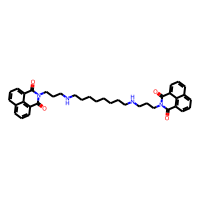
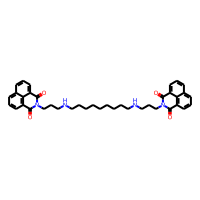
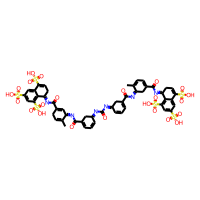
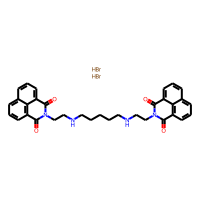
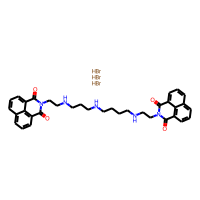
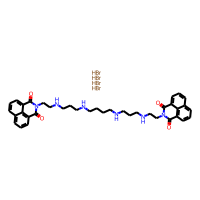
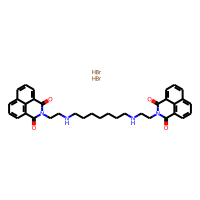
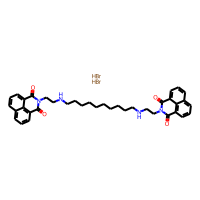
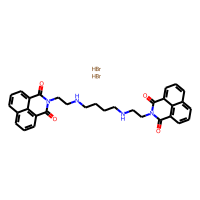
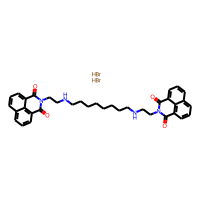
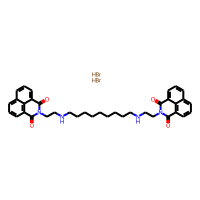
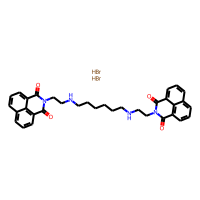
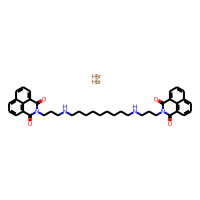
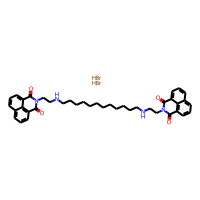
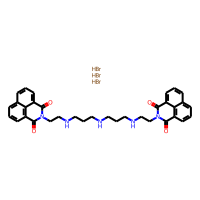
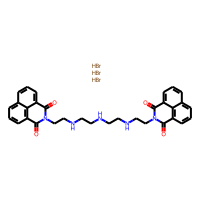

In [594]:
#Drawing molecules

PandasTools.AddMoleculeColumnToFrame(compounds_df, "smiles")
compounds_df

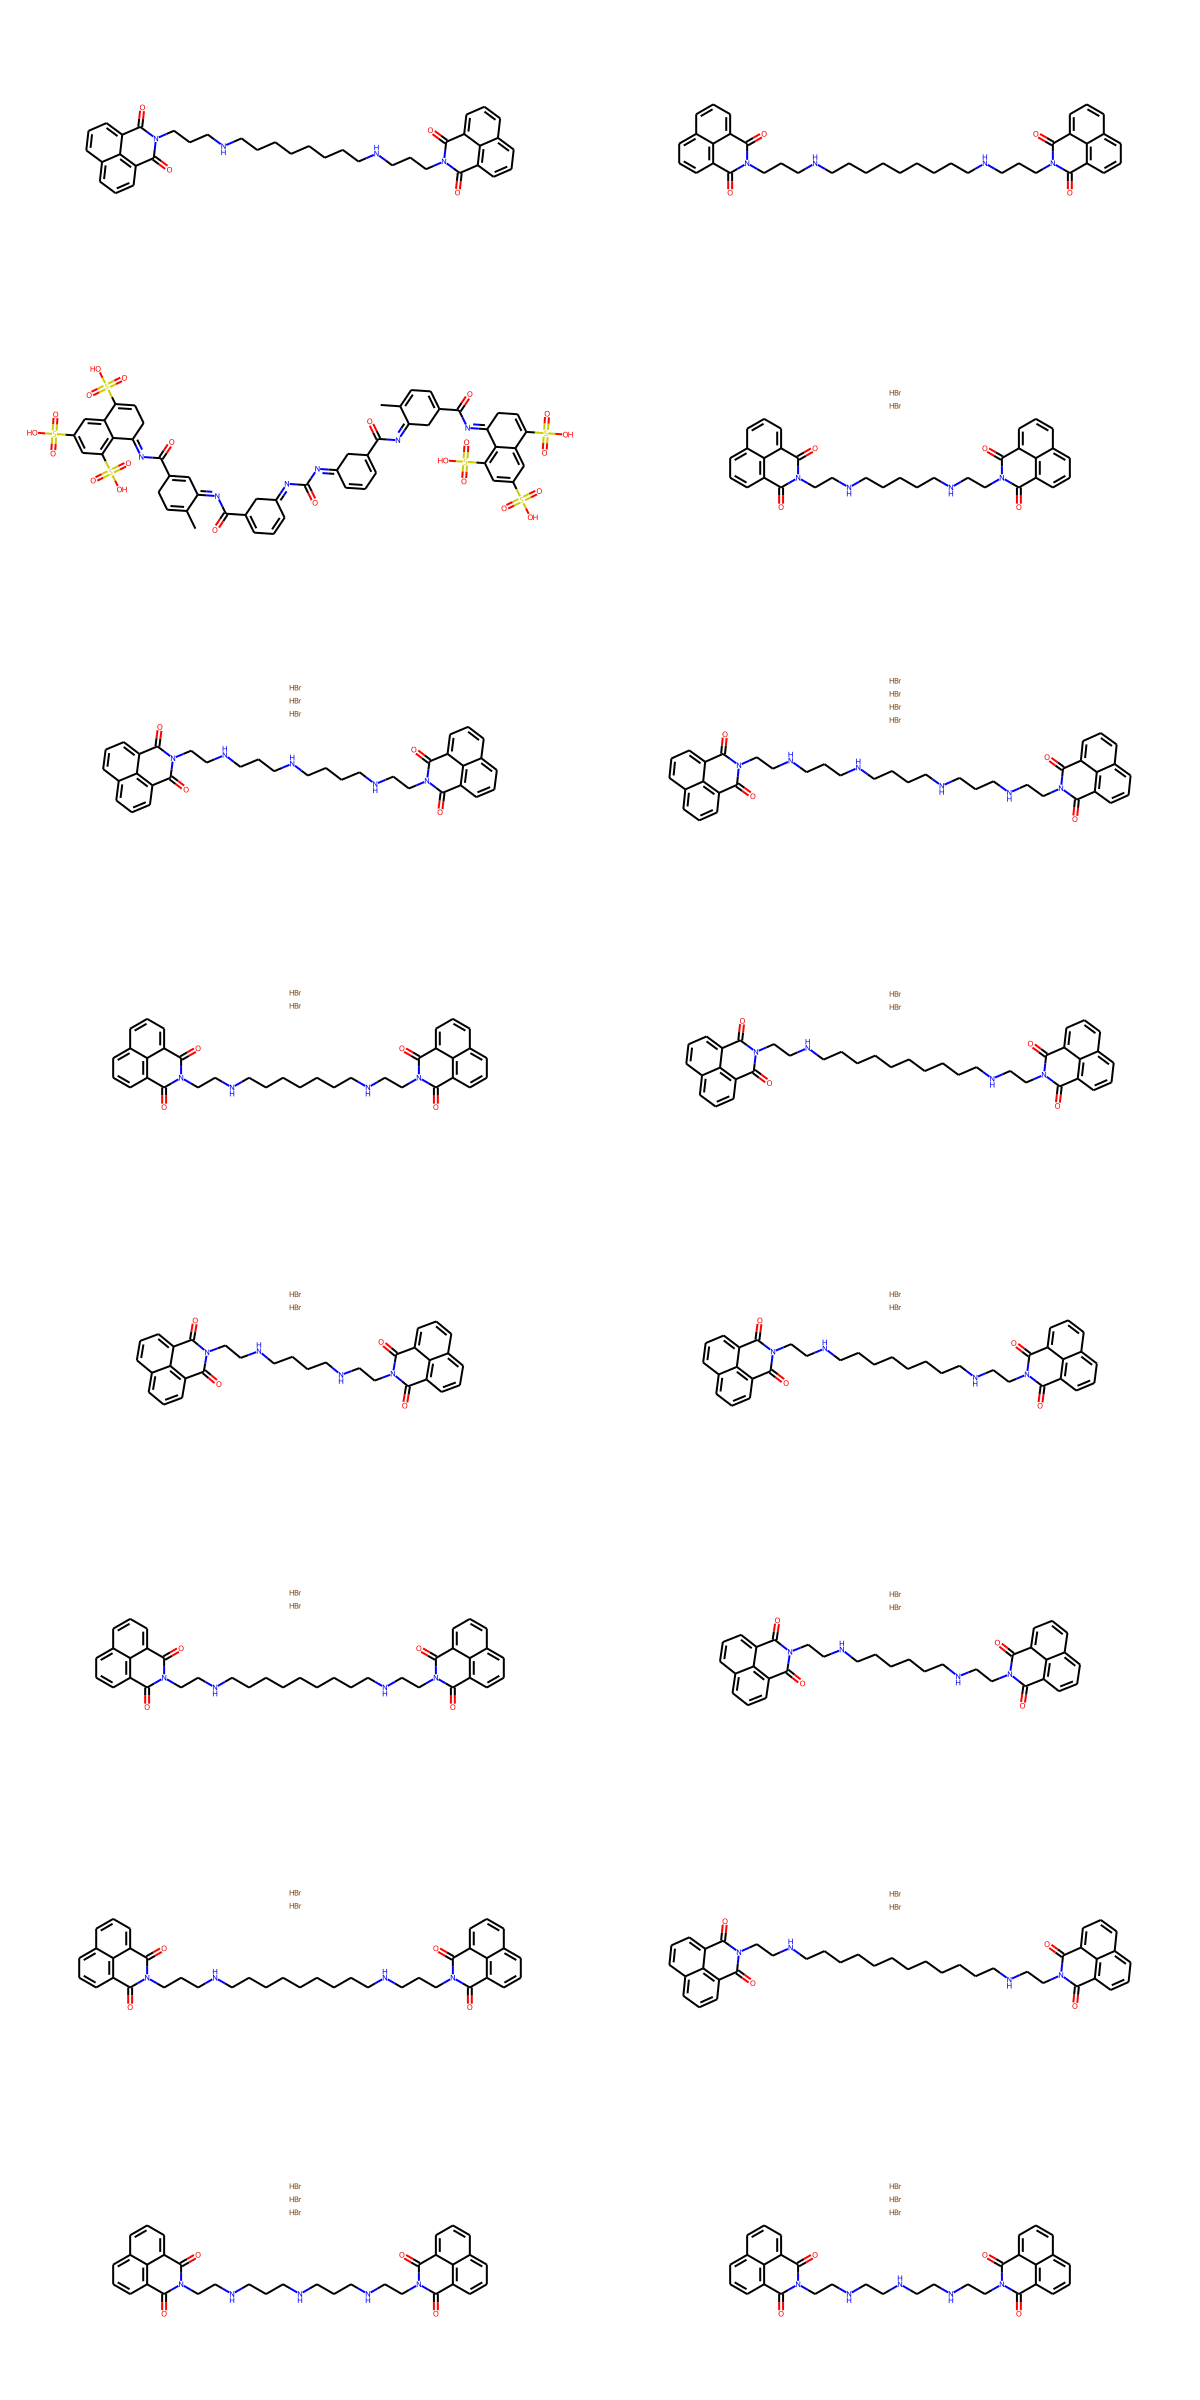

In [595]:
#Draw mol to grid
#draw grid of molecules 
Draw.MolsToGridImage(
    list(compounds_df['ROMol']),
    molsPerRow=2,
    subImgSize=(600,300)
)

## Selecting synthesizable molecules from VEHICLe dataset 

In [596]:
#Importing VEHICLe datgaset
URL = 'https://raw.githubusercontent.com/arturcgs/steel_project/main/data_exploration/VEHICLe.csv'
VEHICLe = pd.read_csv(URL)
VEHICLe.shape

(24867, 6)

In [597]:
#selecting molecules with p(good) above or equal 0.90
VEHICLe_good = VEHICLe[VEHICLe['Pgood'] >= 0.9].copy()
VEHICLe_good.shape

(3593, 6)

,Regid,Smiles,Training_dataset_hits,Beilstein_hits_June_08,Pgood,Tautomer_cluster,ROMol
0,S1,c1cc[nH]c1,81848,NaN,0.99,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1,S10,c1c[nH]nn1,7925,NaN,0.98,2.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,S100,O=C1C=CSC=C1,7,375.0,0.92,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
21,S10016,O=C1NN=Cc2c[nH]cc12,22,37.0,0.98,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
22,S10017,O=C1NN=Cc2cocc12,10,5.0,0.98,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
...,...,...,...,...,...,...,...
24804,S9942,O=C1NC(=O)c2nnncc2S1,0,0.0,0.92,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
24812,S995,O=C1Oc2ccsc2SC1=O,0,0.0,0.92,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
24823,S996,O=C1Oc2sccc2SC1=O,0,0.0,0.92,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
24852,S9986,O=C1Sc2cnnnc2S1,0,0.0,0.93,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

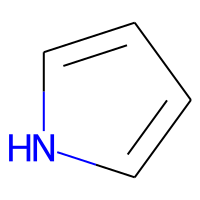
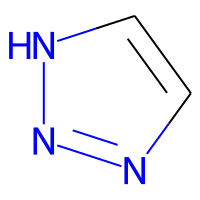
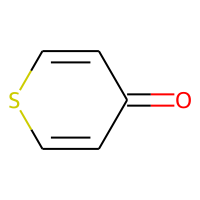
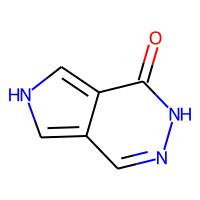
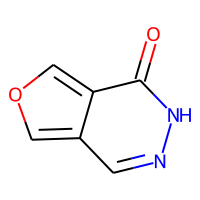
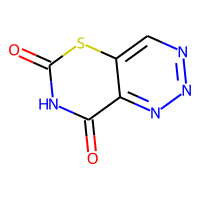
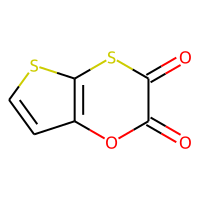
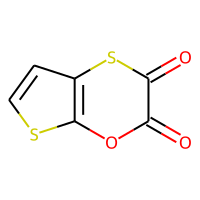
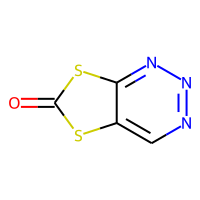
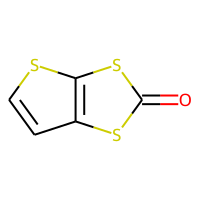

In [598]:
#Draw Mol molecules
PandasTools.AddMoleculeColumnToFrame(VEHICLe_good, "Smiles")
VEHICLe_good

## Checking substructure hits

In [599]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(compounds_df.iterrows(), total=compounds_df.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in VEHICLe_good.iterrows():
        if molecule.HasSubstructMatch(substructure.ROMol):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.ROMol,
                    "substructure_name": substructure["Regid"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
compounds_df = compounds_df.loc[clean]

  0%|          | 0/16 [00:00<?, ?it/s]

In [600]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found substructure hits: {len(matches)}")
print(f"Number of compounds without substructure hits: {len(compounds_df)}")

Number of found substructure hits: 31
Number of compounds without substructure hits: 0


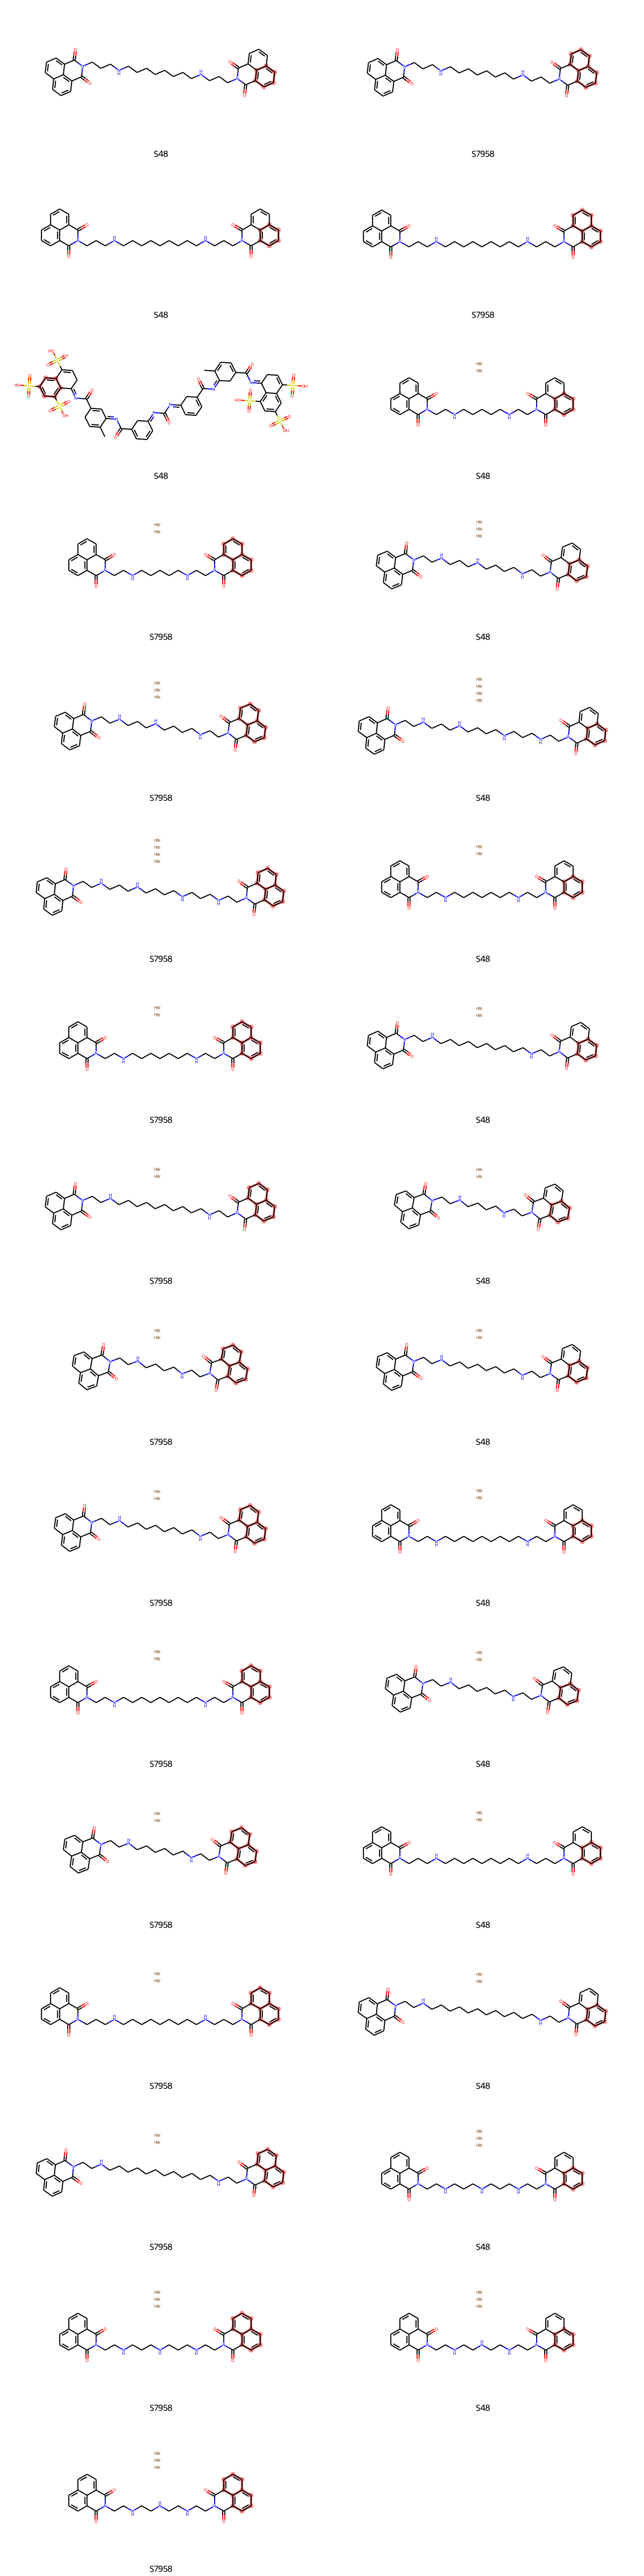

In [601]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(31).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(31).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(31).substructure_name),
    molsPerRow=2,
    subImgSize=(600,300)    
)

In [602]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
S48      16
S7958    15
dtype: int64